https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

## 1. Dependencies

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True) #/content/<any_name>

Mounted at /content/drive/


In [ ]:
#Mount google drive and check if the files are there
!ls /content/drive/MyDrive/G_colab/Colab_dataset/customer_propensity_to_buy/

testing_sample.csv  training_sample.csv


In [ ]:
#installing dependencies
#pip install xgboost

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay #it will plot confusion matrix graphically
import pickle

## 2. Data Exploration

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/G_colab/Colab_dataset/customer_propensity_to_buy/training_sample.csv")
evaluation_df = pd.read_csv('/content/drive/MyDrive/G_colab/Colab_dataset/customer_propensity_to_buy/testing_sample.csv') # we will use this data as final evaluation

y_test = evaluation_df.ordered
x_test = evaluation_df.drop(columns=['ordered','UserID'])
df.head(5)

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


In [ ]:
#check if all userids are unique # True means all are unique

df.UserID.is_unique

True

In [ ]:
#check if theres null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   455401 non-null  object
 1   basket_icon_click        455401 non-null  int64 
 2   basket_add_list          455401 non-null  int64 
 3   basket_add_detail        455401 non-null  int64 
 4   sort_by                  455401 non-null  int64 
 5   image_picker             455401 non-null  int64 
 6   account_page_click       455401 non-null  int64 
 7   promo_banner_click       455401 non-null  int64 
 8   detail_wishlist_add      455401 non-null  int64 
 9   list_size_dropdown       455401 non-null  int64 
 10  closed_minibasket_click  455401 non-null  int64 
 11  checked_delivery_detail  455401 non-null  int64 
 12  checked_returns_detail   455401 non-null  int64 
 13  sign_in                  455401 non-null  int64 
 14  saw_checkout        

Its a imbalance dataset

In [ ]:
#check dataset balance - This will also show if theres any other value in the data other than 0 and 1 and Null
for i in df.columns:
  if i != 'UserID':
    print(df[i].value_counts())

0    410248
1     45153
Name: basket_icon_click, dtype: int64
0    421464
1     33937
Name: basket_add_list, dtype: int64
0    403979
1     51422
Name: basket_add_detail, dtype: int64
0    438620
1     16781
Name: sort_by, dtype: int64
0    443226
1     12175
Name: image_picker, dtype: int64
0    453775
1      1626
Name: account_page_click, dtype: int64
0    448020
1      7381
Name: promo_banner_click, dtype: int64
0    453802
1      1599
Name: detail_wishlist_add, dtype: int64
0    350494
1    104907
Name: list_size_dropdown, dtype: int64
0    447533
1      7868
Name: closed_minibasket_click, dtype: int64
0    426768
1     28633
Name: checked_delivery_detail, dtype: int64
0    451221
1      4180
Name: checked_returns_detail, dtype: int64
0    414957
1     40444
Name: sign_in, dtype: int64
0    418930
1     36471
Name: saw_checkout, dtype: int64
0    455224
1       177
Name: saw_sizecharts, dtype: int64
0    452877
1      2524
Name: saw_delivery, dtype: int64
0    454902
1       499
Na

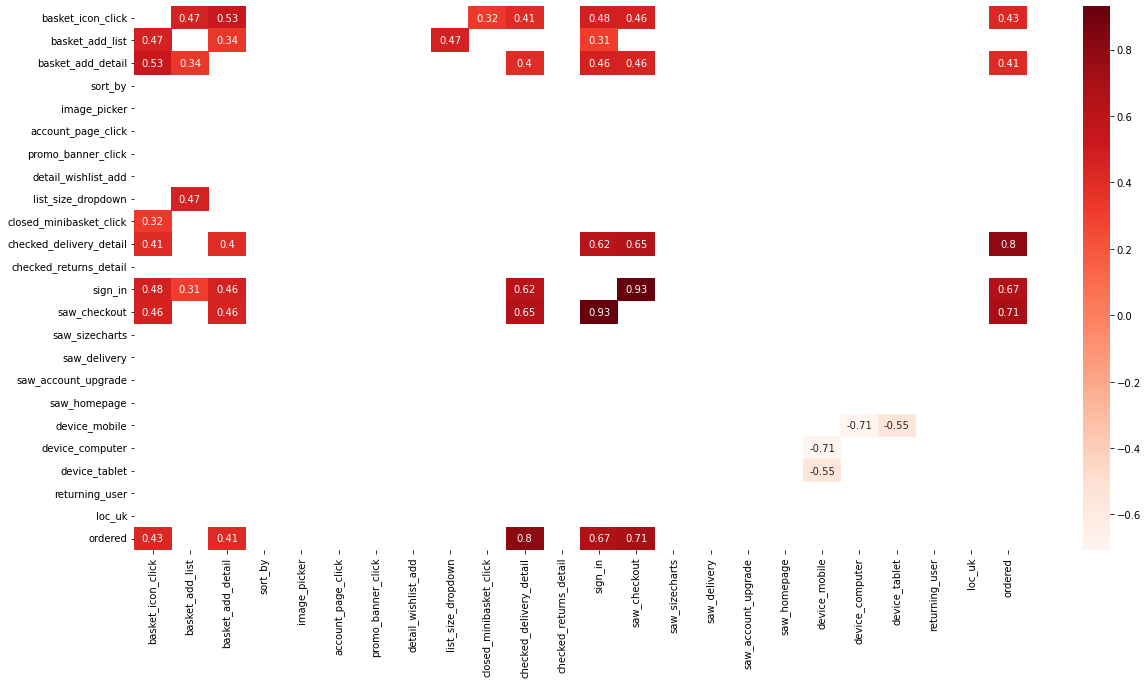

In [ ]:
dfCorr = df.corr()
filteredDf = dfCorr[((dfCorr >= .3) | (dfCorr <= -.3)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")

plt.show()

From this we can see **ordered** has more correlationg with those 5 columns

In [ ]:
x = df.drop(columns=['UserID', 'ordered'])
y = df.ordered

In [ ]:
#shuffling just to make sure no feature is contant over a big chunk of dataset - Since we are using tree based models(due to the way bootstraping works)

xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.15, random_state= 42)

print(len(xtrain), len(xtest), len(ytrain), len(ytest))

387090 68311 387090 68311


## 3. Tuning and Evaluation

In [ ]:
def model_evaluate(model, features=x_test, labels=y_test, feature_importances=True, **kwargs):
  test_predict = model.predict(features)

  # check if zero_division is there - If will be True only if zero_division is not in kwargs
  if kwargs.get('zero_division') is True:
    print(classification_report(labels, test_predict, target_names=['Not ordered', 'Ordered']))
  else: 
    print(classification_report(labels, test_predict, target_names=['Not ordered', 'Ordered'], zero_division=1))


  if feature_importances:
    feat_imp = pd.DataFrame(data= model.feature_importances_, index=features.columns, columns=['Importance']).sort_values('Importance', ascending=False)
    plt.figure(figsize=(7,7))  
    sns.barplot(data=feat_imp, x='Importance', y=feat_imp.index)
    plt.title(f'Feature importance of {model.__class__.__name__}')
    plt.show()


## 4. Models

### 4.1 XGBoost

              precision    recall  f1-score   support

 Not ordered       1.00      0.99      1.00     65448
     Ordered       0.86      0.99      0.92      2863

    accuracy                           0.99     68311
   macro avg       0.93      0.99      0.96     68311
weighted avg       0.99      0.99      0.99     68311



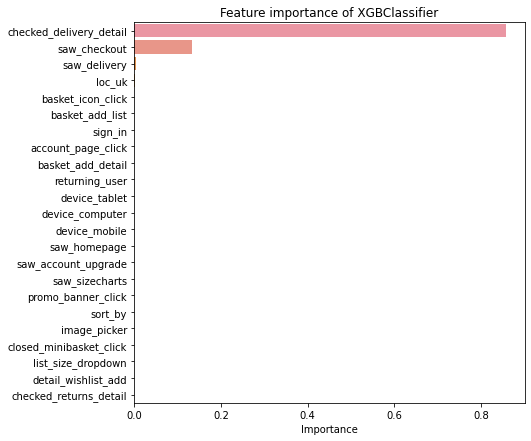

In [ ]:
#parameter setting
xgb_model = XGBClassifier(objective="binary:logistic", learning_rate= 0.1, max_depth= 3, n_estimators= 10, n_jobs= -1, random_state=42) 
#n_jobs is for multi processing

#model fit
xgb_model.fit(xtrain,ytrain)

#model evaluation
model_evaluate(xgb_model, features = xtest, labels = ytest)

From this we can say that though n_estimator was 1000 is has almost the same performance as n_estimator =100 so we can have 100 and now hypertune the model

### 4.2 Random Forest Classifier


              precision    recall  f1-score   support

 Not ordered       0.99      1.00      0.99     65448
     Ordered       0.88      0.73      0.80      2863

    accuracy                           0.98     68311
   macro avg       0.94      0.86      0.89     68311
weighted avg       0.98      0.98      0.98     68311



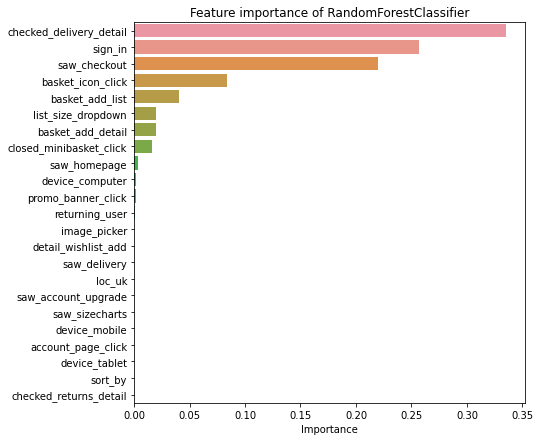

In [ ]:
rfc_model = RandomForestClassifier(n_estimators= 15, criterion= "gini", max_depth = 3,random_state = 42)
#there is no much difference between entropy and gini criterial seperation

rfc_model.fit(xtrain,ytrain)

model_evaluate(rfc_model, features = xtest, labels = ytest)

### 4.3 Decision Tree

              precision    recall  f1-score   support

 Not ordered       1.00      0.99      1.00    151655
     Ordered       0.00      1.00      0.00         0

    accuracy                           0.99    151655
   macro avg       0.50      1.00      0.50    151655
weighted avg       1.00      0.99      1.00    151655



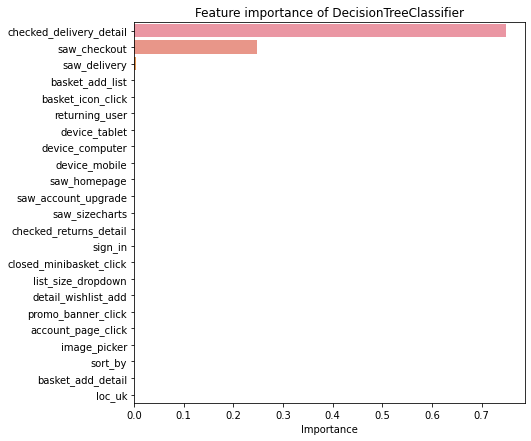

In [ ]:
dec_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, random_state=42)

dec_model.fit(xtrain,ytrain)

model_evaluate(dec_model, xtest= xtest, ytest= ytest, feature_importances=True)

## Predicting on actual data

In [ ]:
#lets check the test data 
print('Actual_value: ',evaluation_df.ordered.value_counts())

Actual_value:  0    151655
Name: ordered, dtype: int64



As we can see that the test data has only non-ordered i.e 0 label data so we can set the zero division to classification report so we won't think there's a issue with the dataset - not the best way to evaluate but we are sticking with the actual data set we found


 Evaluation of XGBClassifier model
              precision    recall  f1-score   support

 Not ordered       1.00      0.99      1.00    151655
     Ordered       0.00      1.00      0.00         0

    accuracy                           0.99    151655
   macro avg       0.50      1.00      0.50    151655
weighted avg       1.00      0.99      1.00    151655



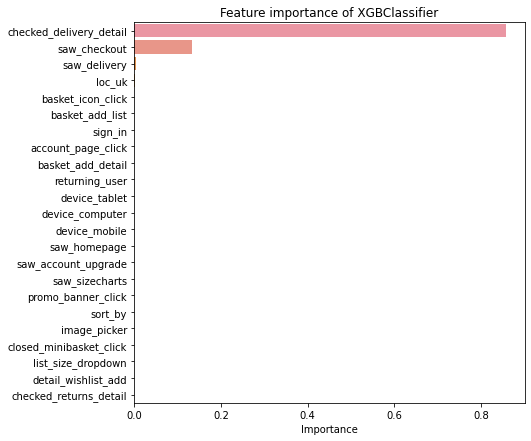


 Evaluation of RandomForestClassifier model
              precision    recall  f1-score   support

 Not ordered       1.00      0.99      1.00    151655
     Ordered       0.00      1.00      0.00         0

    accuracy                           0.99    151655
   macro avg       0.50      1.00      0.50    151655
weighted avg       1.00      0.99      1.00    151655



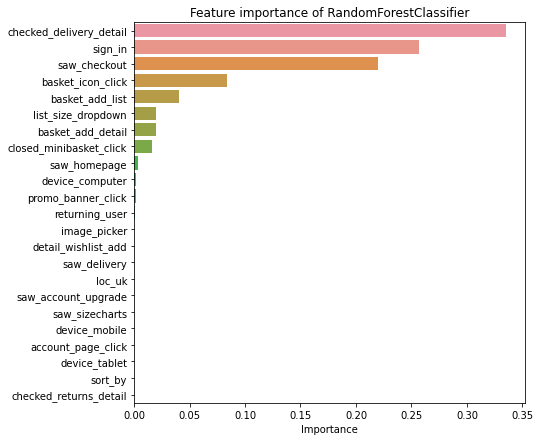


 Evaluation of DecisionTreeClassifier model
              precision    recall  f1-score   support

 Not ordered       1.00      0.99      1.00    151655
     Ordered       0.00      1.00      0.00         0

    accuracy                           0.99    151655
   macro avg       0.50      1.00      0.50    151655
weighted avg       1.00      0.99      1.00    151655



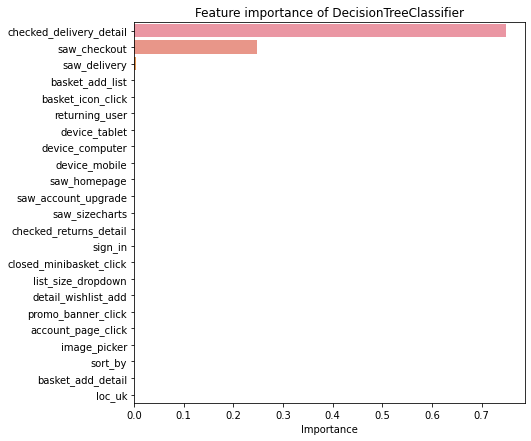

In [ ]:
for model in [xgb_model, rfc_model, dec_model]:
  print('\n',f"Evaluation of {model.__class__.__name__} model")
  model_evaluate(model, zero_division= 1)

## Save the model

In [ ]:
!mkdir /content/model/

mkdir: cannot create directory ‘/content/model/’: File exists


In [ ]:
#Lets save the best model - Since all 3 are similiar 

pickle.dump(xgb_model, open('/content/model/xgb_model.pkl','wb'))
pickle.dump(rfc_model, open('/content/model/rfc_model.pkl','wb'))
pickle.dump(dec_model, open('/content/model/dec_model.pkl','wb'))


In [ ]:
!du -sh /content/model/*

4.0K	/content/model/dec_model.pkl
20K	/content/model/rfc_model.pkl
8.0K	/content/model/xgb_model.pkl


Since all the 3 models are doing the work. I would go with xgb_model as we can even fine tune the model for future data